In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

In [14]:
[1 for i in range(5)]

[1, 1, 1, 1, 1]

In [13]:
a.extend

<function list.extend(iterable, /)>

In [9]:
np.random.normal(loc=[0,0,0],scale=[1,1,1])

array([0.29493165, 0.95470919, 0.50512524])

In [15]:
class N_Armed_Bandit():
    
    def __init__(self, game, play, n_arms, control_paras,
                 whether_stationary = 1,
                 initial_addup = 0,
                 burning_period=1,
                 step_size = None,
                 selection_method='softmax',
                 incre_implem=0):
        
        # times of game
        self.game = game
        
        # times of playround during each game
        self.play = play
        
        # how many levers
        self.n_arms = n_arms
        
        # epsilon for epsilon-greedy, tau(tempreture) for softmax
        self.control_paras = control_paras
        
        # how many rounds of burning period are included during the simulation
        self.burning_period = burning_period
        
        # n_unique of control_paras decisdes how many methods are competing
        self.n_group = len(control_paras)
        
        # which method to select action
        self.selection_method = selection_method
        
        # whether use incremental implementation
        self.incre_implem = incre_implem
        
        # whether the state goes stationary, if None, means this is a stationary problem
        self.step_size = step_size
        
        # whether addup some figures on initial zeros
        self.initial_addup = initial_addup
        
        # whether the problem is stationary or nonstationary
        self.whether_stationary = whether_stationary
        
        
    def __DataRestoration(self):
        
        # True rewards, fixed for each game
        self.true_rwd = np.random.normal(0,1,self.n_arms)
        self.best_action = np.argmax(self.true_rwd)
        
        # Estimated reward, update after each play
        self.estimated_rwd = np.zeros((self.n_group,self.n_arms))+self.initial_addup
        
        # Record total reward of each action, update after each play
        self.acc_action_rwd = np.zeros((self.n_group,self.n_arms))           
        
        # Track the times each action taken, used for update estimated reward when incre_implem=0, 
        # and for calculate optimal_choice%
        self.action_times = np.zeros((self.n_group,self.n_arms))
        
        # Track the optimal action taken percentage in each playround
        self.optimal_taken_percentage = np.zeros((self.n_group,self.play))

        # Track the accumulated reward during the play
        self.acc_rwd_track = np.zeros((self.n_group,self.play))   
        
        # Track the greedy action reward in each playround
        self.greedy_action_rwd_track = np.zeros((self.n_group,self.play))
       
    
    # Similar to MCMC to generate nonstationary tasks
    def __Nonstationary(self):
        
        if self.whether_stationary==0:
            
            last_true_rwd = list(self.true_rwd)
            scales = [1 for i in range(self.n_arms)]
            self.true_rwd = np.random.normal(loc=last_true_rwd,
                                             scale=scales)
            self.best_action = np.argmax(self.true_rwd)
        
        
    def Softmax_selection(self,Q_t):
        
        # reshape paras, to adapt numpy array computation
        tau = np.array(self.control_paras).reshape(self.n_group,-1)
        
        numerator = np.exp(Q_t/tau)
        denominator = numerator.sum(axis=1,keepdims=True)
        softmax_prob = numerator/denominator
        
        a=[]
        exploiting=[]
        
        for i in range(self.n_group):
                    
            a_temp = np.random.choice(list(range(self.n_arms)),p=softmax_prob[i,:])
            exploiting_temp = int(np.argmax(softmax_prob[i,:]))
            
            a.append(a_temp)
            exploiting.append(exploiting_temp)
            
        return a,exploiting
     
    def Epsilon_greedy_selection(self,Q_t):

        greedy_prob = np.random.uniform(0,1)
        a = []
        exploiting = []
        
        for i in range(self.n_group):

            if self.control_paras[i]==0:
                a_temp = int(np.argmax(self.estimated_rwd[i,:]))
                exploiting_temp = a_temp
                a.append(a_temp)
                exploiting.append(exploiting_temp)
            else:
                exploring = list(range(self.n_arms))
                exploiting_temp = np.argmax(self.estimated_rwd[i,:])
                exploring.remove(exploiting_temp)
                a_temp = int((greedy_prob<=self.control_paras[i])*np.random.choice(exploring))+int((greedy_prob>self.control_paras[i])*exploiting_temp)
                a.append(a_temp)
                exploiting.append(exploiting_temp)
                
        return a,exploiting
    
    def UCB(self,Q_t,p):
        
        a = []
        exploiting = []
        
        for i in range(self.n_group):
            
            if 0 in self.action_times[i,:]:
                choices = np.where(self.action_times[i,:]==0)[0]
                a_temp = np.random.choice(choices)
                exploiting_temp = np.argmax(Q_t[i,:])
            else:
                a_temp = np.argmax(Q_t[i,:]+self.control_paras[i]*np.sqrt(np.log(p)/self.action_times[i,:]))
                exploiting_temp = np.argmax(Q_t[i,:])
            
            a.append(a_temp)
            exploiting.append(exploiting_temp)
            
        return a, exploiting
              
    def Choose_action(self,p):
        
        # Strategy During Burning Period
        if p < self.burning_period:
            
            a = np.random.randint(0,self.n_arms,self.n_group)
            exploiting = a
            
        # Strategy After Burning Period
        else:
            
            # Softmax Action Selection
            # ------------------------
            if self.selection_method=='softmax':
                
                a,exploiting = self.Softmax_selection(self.estimated_rwd)
                
            # Epsilon-Greedy Strategy 
            # ------------------------
            if self.selection_method=='epsilon':
                
                a,exploiting = self.Epsilon_greedy_selection(self.estimated_rwd)
                
            # Uppeer-Bound-Confidence Selection
            # ---------------------------------
            if self.selection_method=='UCB':
                
                a,exploiting = self.UCB(self.estimated_rwd,p)
                
        return a,exploiting
    
    def Update_Rewards(self,a,p,exploiting):
        
        for i in range(self.n_group):

            # update action times taken
            self.action_times[i,a[i]] += 1
            
            current_reward = np.random.normal(self.true_rwd[a[i]],1)
            
            if self.incre_implem==0:
                # update accumulated rewards of each action
                self.acc_action_rwd[i,a[i]] += current_reward

                # update estimated reward of each action
                self.estimated_rwd[i,a[i]] = self.acc_action_rwd[i,a[i]]/self.action_times[i,a[i]]
                
            if self.incre_implem==1:
                
                self.acc_action_rwd[i,a[i]] += current_reward
                
                if self.step_size == None:
                    self.estimated_rwd[i,a[i]] = self.estimated_rwd[i,a[i]] + (current_reward-self.estimated_rwd[i,a[i]])/(1+self.action_times[i,a[i]])
                else:
                    self.estimated_rwd[i,a[i]] = self.estimated_rwd[i,a[i]] + self.step_size*(current_reward-self.estimated_rwd[i,a[i]])
                
        # record the accumulated reward
        self.acc_rwd_track[:,p] = self.acc_action_rwd.sum(axis=1)/(p+1)
        
    def Track_Greedy(self,a,p,exploiting):
        
        for i in range(self.n_group):
            
            if p==0:
                # update optimal action reward
                self.greedy_action_rwd_track[i,p] = np.random.normal(self.true_rwd[exploiting[i]],1)
            else:
                self.greedy_action_rwd_track[i,p] = (p*(self.greedy_action_rwd_track[i,p-1])+np.random.normal(self.true_rwd[exploiting[i]],1))/(p+1) 
                
    def Track_Optimal(self,p):
        
        for i in range(self.n_group):
            
            self.optimal_taken_percentage[i,p] = self.action_times[i,self.best_action]/(p+1)
    
    def ReadyPlayer(self):
        
        # Track the accumulated reward after each game
        self.total_game_rwd_track = np.zeros((self.n_group,self.play))  
        
        # Track the accumulated reward after each game
        self.total_greedy_action_rwd_track = np.zeros((self.n_group,self.play)) 
        
        # Track the accumulated best action taken percentage after each game
        self.total_optimal_taken_percentage = np.zeros((self.n_group,self.play)) 
        
        for g in range(self.game):
            
            start = time.time()
            
            # each game need new data restoration
            self.__DataRestoration()
            
            for p in range(self.play):
                
                if self.whether_stationary==0 and p>=1:
                    self.__Nonstationary()
                
                a,exploiting=self.Choose_action(p)
                self.Update_Rewards(a,p,exploiting)
                self.Track_Greedy(a,p,exploiting)
                self.Track_Optimal(p)
                
            self.total_game_rwd_track += self.acc_rwd_track  
            self.total_greedy_action_rwd_track += self.greedy_action_rwd_track
            self.total_optimal_taken_percentage += self.optimal_taken_percentage
            
            end = time.time()
            print('game{} finished, time cost {}seconds'.format(g,np.round(end-start,4)))
            
        self.total_game_rwd_track = self.total_game_rwd_track/self.game
        self.total_greedy_action_rwd_track = self.total_greedy_action_rwd_track/self.game
        self.total_optimal_taken_percentage = self.total_optimal_taken_percentage/self.game
        
        self.reward_data = pd.DataFrame(self.total_game_rwd_track[:,self.burning_period:]).T
        self.greedy_action = pd.DataFrame(self.total_greedy_action_rwd_track[:,self.burning_period:]).T
        self.optimal_taken = pd.DataFrame(self.total_optimal_taken_percentage[:,self.burning_period:]).T
        
        if self.selection_method=='softmax':
            self.reward_data.columns = ['tau='+str(i) for i in self.control_paras]
            self.greedy_action.columns = ['tau='+str(i) for i in self.control_paras]
            self.optimal_taken.columns = ['tau='+str(i) for i in self.control_paras]
            
        if self.selection_method=='epsilon':
            self.reward_data.columns = ['epsilon='+str(i) for i in self.control_paras]
            self.greedy_action.columns = ['epsilon='+str(i) for i in self.control_paras]
            self.optimal_taken.columns = ['epsilon='+str(i) for i in self.control_paras]
            
        if self.selection_method=='UCB':
            self.reward_data.columns = ['c='+str(i) for i in self.control_paras]
            self.greedy_action.columns = ['c='+str(i) for i in self.control_paras]
            self.optimal_taken.columns = ['c='+str(i) for i in self.control_paras]

In [16]:
# Epsilon-Greedy Strategy
RP1 = N_Armed_Bandit(game=50,play=4000,n_arms=10,
                     control_paras=[0,0.01,0.1,0.3,0.5],
                     whether_stationary=1,
                     initial_addup=0,
                     burning_period=1,
                     selection_method='epsilon',incre_implem=1)
# Softmax Strategy
RP2 = N_Armed_Bandit(game=50,play=4000,n_arms=10,
                     control_paras=[0.01,0.1,0.5,1,2],
                     whether_stationary=1,
                     initial_addup=0,
                     burning_period=1,
                     selection_method='softmax',incre_implem=1)

# Upper-Bound-Confidence Strategy
RP3 = N_Armed_Bandit(game=50,play=4000,n_arms=10,
                     control_paras=[0.01,0.1,0.5,1,2],
                     whether_stationary=1,
                     initial_addup=0,
                     burning_period=1,
                     selection_method='UCB',incre_implem=1)

In [174]:
RP1.ReadyPlayer()

game0 finished, time cost 0.9499seconds
game1 finished, time cost 1.0751seconds
game2 finished, time cost 1.2997seconds
game3 finished, time cost 1.0517seconds
game4 finished, time cost 0.9911seconds
game5 finished, time cost 0.9717seconds
game6 finished, time cost 1.0248seconds
game7 finished, time cost 1.0793seconds
game8 finished, time cost 0.9712seconds
game9 finished, time cost 1.0161seconds
game10 finished, time cost 1.0884seconds
game11 finished, time cost 1.0712seconds
game12 finished, time cost 1.0053seconds
game13 finished, time cost 1.1124seconds
game14 finished, time cost 0.9763seconds
game15 finished, time cost 0.9875seconds
game16 finished, time cost 1.003seconds
game17 finished, time cost 1.0128seconds
game18 finished, time cost 1.0307seconds
game19 finished, time cost 0.9805seconds
game20 finished, time cost 1.061seconds
game21 finished, time cost 1.0756seconds
game22 finished, time cost 0.9932seconds
game23 finished, time cost 0.9725seconds
game24 finished, time cost 1

In [175]:
RP2.ReadyPlayer()

game0 finished, time cost 1.2766seconds
game1 finished, time cost 1.4204seconds
game2 finished, time cost 1.8234seconds
game3 finished, time cost 1.8128seconds
game4 finished, time cost 1.4285seconds
game5 finished, time cost 1.4085seconds
game6 finished, time cost 1.831seconds
game7 finished, time cost 1.4262seconds
game8 finished, time cost 1.3595seconds
game9 finished, time cost 1.3564seconds
game10 finished, time cost 1.3528seconds
game11 finished, time cost 1.3632seconds
game12 finished, time cost 1.346seconds
game13 finished, time cost 1.3551seconds
game14 finished, time cost 1.3451seconds
game15 finished, time cost 1.3598seconds
game16 finished, time cost 1.294seconds
game17 finished, time cost 1.3574seconds
game18 finished, time cost 1.3657seconds
game19 finished, time cost 1.3505seconds
game20 finished, time cost 1.3621seconds
game21 finished, time cost 1.3096seconds
game22 finished, time cost 1.3102seconds
game23 finished, time cost 1.3342seconds
game24 finished, time cost 1.

In [170]:
RP3.ReadyPlayer()

game0 finished, time cost 0.8569seconds
game1 finished, time cost 0.8513seconds
game2 finished, time cost 0.9129seconds
game3 finished, time cost 0.8076seconds
game4 finished, time cost 0.8697seconds
game5 finished, time cost 0.8622seconds
game6 finished, time cost 0.8617seconds
game7 finished, time cost 0.8841seconds
game8 finished, time cost 0.8515seconds
game9 finished, time cost 0.8427seconds
game10 finished, time cost 0.7982seconds
game11 finished, time cost 0.8348seconds
game12 finished, time cost 0.8439seconds
game13 finished, time cost 0.863seconds
game14 finished, time cost 0.827seconds
game15 finished, time cost 0.7971seconds
game16 finished, time cost 0.8368seconds
game17 finished, time cost 0.8749seconds
game18 finished, time cost 0.8797seconds
game19 finished, time cost 0.8808seconds
game20 finished, time cost 0.8552seconds
game21 finished, time cost 0.8641seconds
game22 finished, time cost 0.89seconds
game23 finished, time cost 0.8645seconds
game24 finished, time cost 0.8

**Realistic Accumulated Rewards Under Each Strategy**

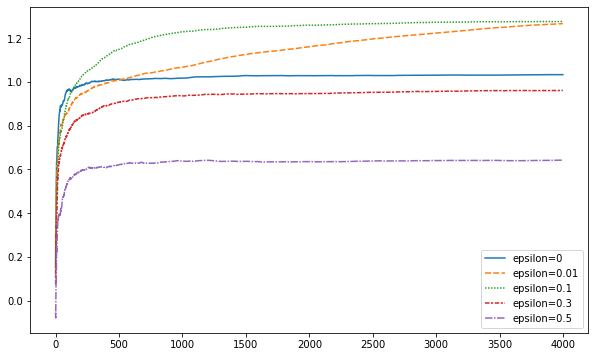

In [176]:
# Epsilon-greedy strategy, total average rewards after 50 games with 4000 playing rounds for each
plt.figure(figsize=(10,6))
sns.lineplot(data = RP1.reward_data)

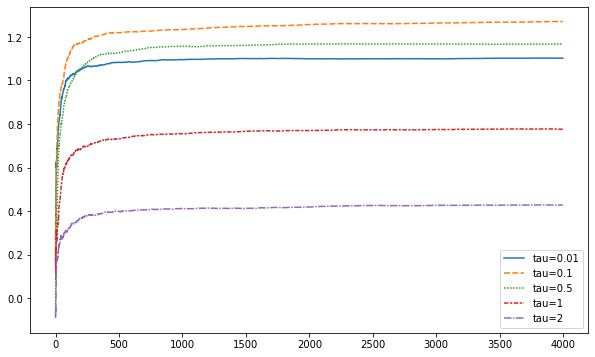

In [177]:
# Softmax strategy, total average rewards after 50 games with 4000 playing rounds for each
plt.figure(figsize=(10,6))
sns.lineplot(data = RP2.reward_data)

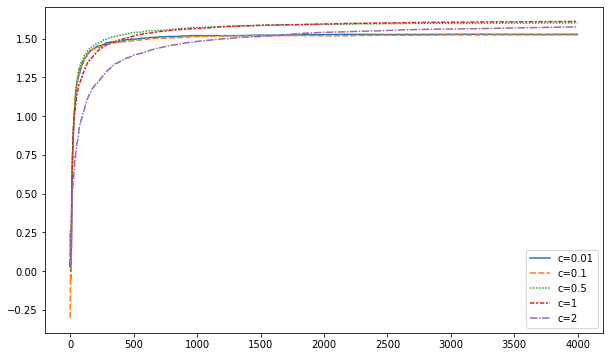

In [172]:
# UCB strategy, total average rewards after 50 games with 4000 playing rounds for each
plt.figure(figsize=(10,6))
sns.lineplot(data = RP3.reward_data)

**Accumulated Rewards if Always Select Greedy Action**

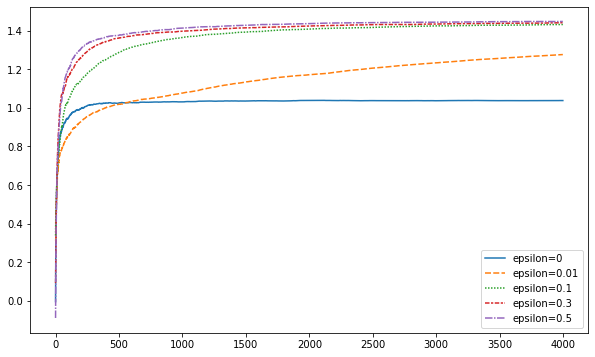

In [178]:
# Epsilon-greedy strategy, total average rewards under greedy action selection
plt.figure(figsize=(10,6))
sns.lineplot(data = RP1.greedy_action)

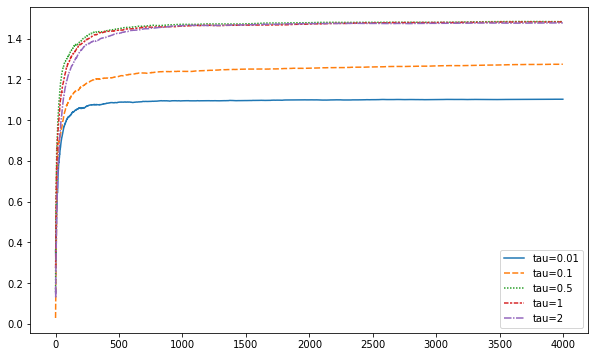

In [179]:
# Softmax strategy, total average rewards under greedy action selection
plt.figure(figsize=(10,6))
sns.lineplot(data = RP2.greedy_action)

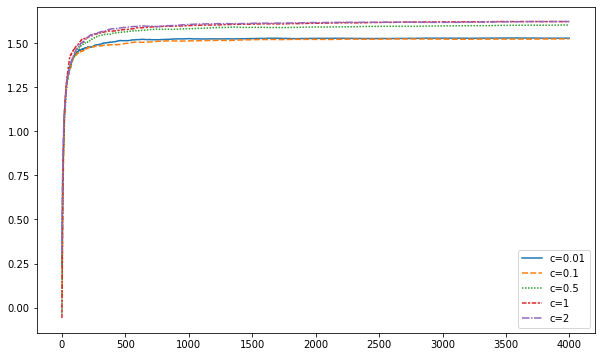

In [180]:
# UCB strategy, total average rewards under greedy action selection
plt.figure(figsize=(10,6))
sns.lineplot(data = RP3.greedy_action)

**Percentage of Selecting Optimal Actions**

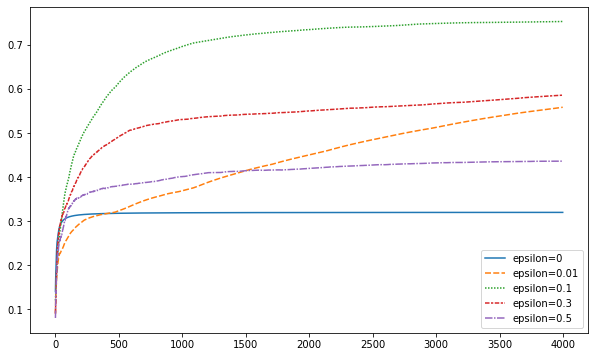

In [181]:
# Epsilon-greedy strategy, optimal actions taken percentage
plt.figure(figsize=(10,6))
sns.lineplot(data = RP1.optimal_taken)

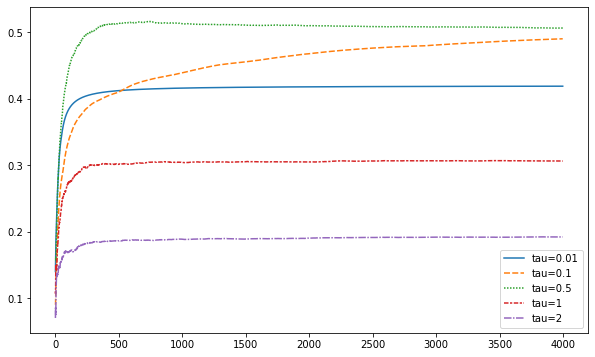

In [182]:
# Softmax strategy, optimal actions taken percentage
plt.figure(figsize=(10,6))
sns.lineplot(data = RP2.optimal_taken)

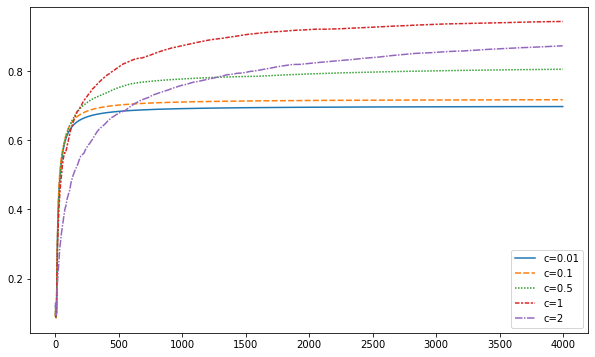

In [183]:
# UCB strategy, optimal actions taken percentage
plt.figure(figsize=(10,6))
sns.lineplot(data = RP3.optimal_taken)